In [1]:
#import library
import numpy as np
import pandas as pd
from datetime import date
from neupy import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import keras
from keras import regularizers
import pyrenn as prn
from keras.callbacks import EarlyStopping

c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\qqwea1223\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\user

In [2]:
file_parameters = ['ch', 'cv', 'cc']
plant_date = '0401'
limit_day = 105
interval_day = 7
x_pred = range(interval_day, limit_day+1, interval_day)
path = 'sigmoid_2016_spring/sigmoid_2016_spring{}.csv'
# sigmoi_2016_spring_ch.csv
yield_path = '2016_spring/2016_spring.csv'

In [3]:
parameter = 'ch'
term = pd.read_csv(path.format('_'+parameter))
term.head

<bound method NDFrame.head of      max_value  max_growth_rate  half_max_growth_rate  first_day_half_max  \
0     1.132855         0.027922              0.014146                42.0   
1     1.272441         0.028461              0.014705                35.0   
2     1.378696         0.030998              0.015933                37.0   
3     1.405654         0.032263              0.016535                38.0   
4     1.237971         0.030544              0.015534                39.0   
..         ...              ...                   ...                 ...   
800   0.822383         0.022021              0.011086                44.0   
801   0.733356         0.035335              0.017668                59.0   
802   0.786208         0.022304              0.011220                43.0   
803   0.899694         0.023970              0.012153                37.0   
804   0.945828         0.025205              0.012772                37.0   

     second_day_half_max  duration_half_max  

In [6]:
canopy_dataframe = pd.read_csv('2016_spring/2016_spring.csv')
akash_data = pd.read_excel('CH.xlsx', 'Sheet1')
index_mask = pd.read_excel('index_of_considered_samples.xlsx', 'Sheet1', header = None)

In [5]:
mask  = np.isin(canopy_dataframe['order'].values, index_mask.values) & (canopy_dataframe['Weight per row (lbs)'].values > 0)
# print(canopy_dataframe['order'].values.shape)
# print(index_mask.values.shape)
canopy_dataframe = canopy_dataframe[mask]
print(canopy_dataframe.shape)
print(sum(mask))
# print(canopy_dataframe.shape)
# # print(sum(mask_CH))
canopy_dataframe = canopy_dataframe.reset_index()

(760, 162)
760


ValueError: cannot insert level_0, already exists

In [7]:
original_data = canopy_dataframe.copy()

In [8]:
def cottonYieldData(parameters):
    x_normalization_mask = []
    processed_data = {}
    std = parameters['std']
    normalization = parameters['normalization']
    interval_day = parameters['interval_day']
    limit_day = parameters['limit_day']
    
    
    
    plant_date = '0401'
    file_parameters = parameters['file_parameters']
    
    for (i, parameter) in enumerate(file_parameters):
    #     print(type(data[parameter]))
        parameter_data = pd.read_csv(path.format('_'+parameter))
        print(parameter_data.shape)
        parameter_data = parameter_data.values
        if i == 0:
             interval_process_data = np.empty([len(parameter_data), 0])
        if normalization:
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,:3]))
            x_normalization_mask.append(np.linalg.norm(parameter_data[:,3:]))
            parameter_data[:,:3] /= np.linalg.norm(parameter_data[:,:3])
            parameter_data[:,3:] /= np.linalg.norm(parameter_data[:,3:])
            
        interval_process_data = np.append(interval_process_data, parameter_data, axis = 1)
#     print(interval_process_data.shape)
    extra_parameters = data_parameters['extra_parameters']
    for parameter in extra_parameters:
        data = original_data[[x for x in original_data.columns if parameter in x]].copy().values.astype(float)
        x_normalization_mask.append(np.linalg.norm(data))
        data /= np.linalg.norm(data)
        interval_process_data = np.append(interval_process_data, data, axis = 1)
        
#     print(interval_process_data.shape)
    one_hot_encoded_parameters = data_parameters['one_hot_encoded_parameters']
     #Added one hot of irrigation
    for parameter in one_hot_encoded_parameters:
        irrigation = pd.DataFrame(original_data[parameter].copy())
        irrigation_values = np.unique(irrigation)
        irrigation[parameter] = irrigation[parameter].map(lambda x: {value:i for (i, value) in enumerate(irrigation_values)}.get(x))
        irrigation = pd.get_dummies(irrigation[parameter])
        interval_process_data = np.append(interval_process_data, irrigation.values, axis = 1)    
        
#     print(interval_process_data.shape)
#      #Added one hot of plantDate
#     test_plant_date = pd.DataFrame(yield_data['plantDate'])
#     test_plant_data_values = np.unique(yield_data['plantDate'].values)
#     test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
#     test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
#     interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
        
    
    
    x_train = interval_process_data 
    y_train = original_data['Weight per row (lbs)'].copy().values
#     print(y_train.shape)
#     print(x_train.shape)
    

    y_normalization_mask = np.linalg.norm(y_train)
    if normalization:
        y_train /= y_normalization_mask

    return(x_train, y_train, x_normalization_mask, y_normalization_mask)


In [9]:
def process(model_parameters, data_parameters, data_func):
    
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    return(trainModel(x_data, y_data, x_data.shape[1], model_parameters))

In [10]:
def akashModel(x_data, y_data, input_shape, model_parameter):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
#     x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    x_train = x_train.T
    y_train = y_train.T
    x_test = x_test.T
    y_test = y_test.T
    layer_shape = model_parameters['layer']
    kmax = model_parameters['k_max']
    damp_const = model_parameters['dampconst']
    damp_fac = model_parameters['dampfac']
    E_stop = model_parameters['E_stop']
    verbose = model_parameters['verbose']

    net = prn.CreateNN(np.append(np.append(input_shape, layer_shape), 1))
    net = prn.train_LM(x_train, y_train, net, verbose=verbose,
    dampfac = damp_fac, dampconst = damp_const,
    k_max=kmax, E_stop= E_stop)
    
    y = prn.NNOut(x_train, net)
    y_pred = prn.NNOut(x_test, net)
    acc_sc_chk = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': y.flatten()})
    acc_sc_chk.head()
    r2_score_1 = r2_score(acc_sc_chk.y_train, acc_sc_chk.y_train_pred)
    print('r2 score = ', r2_score_1, '/ 1.0')

    acc_sc_chk_2 = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': y_pred.flatten()})
    acc_sc_chk_2.head()
    r2_score_2 = r2_score(acc_sc_chk_2.y_test, acc_sc_chk_2.y_test_pred)
    print('r2 score = ', r2_score_2, '/ 1.0')
    
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 6))
    ax[0].scatter(range(len(y_train)), y_train, color = 'black', label = 'test')
    ax[0].scatter(range(len(y)), y, color = 'red', label = 'predict')
    ax[0].set_xlabel('observation')
    ax[0].set_ylabel('yield')
    ax[0].set_title('compare train and predict')
    ax[0].legend(loc = 'upper left' )
    
    ax[1].scatter(range(len(y_test)), y_test, color = 'black', label = 'test')
    ax[1].scatter(range(len(y_test)), y_pred, color = 'red', label = 'predict')
    ax[1].set_xlabel('observation')
    ax[1].set_ylabel('yield')
    ax[1].set_title('compare test and predict')
    ax[1].legend(loc = 'upper left' )
    
    plt.show()

In [11]:
def akashProcess(model_parameters, data_parameters, data_func):
    x_data, y_data, x_normalization_mask, y_normalization_mask = data_func(data_parameters)
    print(x_data.shape)
    print(y_data.shape)
    akashModel(x_data, y_data, x_data.shape[1], model_parameters)

(805, 6)
(805, 6)
(805, 6)
(805, 23)
(805,)
Iteration:  0 		Error:  457.22323860606946 	scale factor:  0.02
Iteration:  1 		Error:  0.10414592700574375 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.018805476005994554 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.016889701440927003 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.016391322431966372 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.016094893862764158 	scale factor:  0.001016105268505817
Iteration:  6 		Error:  0.015597522460883174 	scale factor:  0.001016105268505817
Iteration:  7 		Error:  0.015403020659773302 	scale factor:  0.001016105268505817
Iteration:  8 		Error:  0.015238078926608997 	scale factor:  0.001016105268505817
Iteration:  9 		Error:  0.015102060058945115 	scale factor:  0.001016105268505817
Iteration:  10 		Error:  0.014990151959218944 	scale factor:  0.001016105268505817
Iteration:  11 		Error:  0.014897377913377913 	scale factor:  0.00101

Iteration:  97 		Error:  0.013615017250629727 	scale factor:  0.00037633528463178407
Iteration:  98 		Error:  0.01359209233169105 	scale factor:  0.00037633528463178407
Iteration:  99 		Error:  0.013568870362921507 	scale factor:  0.00037633528463178407
Iteration:  100 		Error:  0.013545379978434715 	scale factor:  0.00037633528463178407
Iteration:  101 		Error:  0.013521661453396805 	scale factor:  0.00037633528463178407
Iteration:  102 		Error:  0.013497769815054081 	scale factor:  0.00037633528463178407
Iteration:  103 		Error:  0.013494449528807536 	scale factor:  0.0001393834387525126
Iteration:  104 		Error:  0.013444383179011636 	scale factor:  0.0001393834387525126
Iteration:  105 		Error:  0.013352097151752085 	scale factor:  0.00037633528463178407
Iteration:  106 		Error:  0.01332919793999662 	scale factor:  0.00037633528463178407
Iteration:  107 		Error:  0.013308193670832021 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.0132879930907597 	scale factor:  

Iteration:  194 		Error:  0.011859011984918184 	scale factor:  0.0001393834387525126
Iteration:  195 		Error:  0.01184124622475315 	scale factor:  0.0001393834387525126
Iteration:  196 		Error:  0.01182342860236443 	scale factor:  0.0001393834387525126
Iteration:  197 		Error:  0.011805565250171525 	scale factor:  0.0001393834387525126
Iteration:  198 		Error:  0.011787658157984411 	scale factor:  0.0001393834387525126
Iteration:  199 		Error:  0.011769704364292397 	scale factor:  0.0001393834387525126
Iteration:  200 		Error:  0.011751695651512364 	scale factor:  0.0001393834387525126
Iteration:  201 		Error:  0.011733618737332965 	scale factor:  0.0001393834387525126
Iteration:  202 		Error:  0.011715455878108403 	scale factor:  0.0001393834387525126
Iteration:  203 		Error:  0.011697185740990539 	scale factor:  0.0001393834387525126
Iteration:  204 		Error:  0.011678784401289066 	scale factor:  0.0001393834387525126
Iteration:  205 		Error:  0.011660226307197711 	scale factor:  0.00

Iteration:  291 		Error:  0.010511721649695428 	scale factor:  0.0001393834387525126
Iteration:  292 		Error:  0.010505720368481868 	scale factor:  0.0001393834387525126
Iteration:  293 		Error:  0.010499740966076117 	scale factor:  0.0001393834387525126
Iteration:  294 		Error:  0.010493782344946094 	scale factor:  0.0001393834387525126
Iteration:  295 		Error:  0.010487843557835438 	scale factor:  0.0001393834387525126
Iteration:  296 		Error:  0.010481923786016034 	scale factor:  0.0001393834387525126
Iteration:  297 		Error:  0.010476022317968127 	scale factor:  0.0001393834387525126
Iteration:  298 		Error:  0.010470138528559752 	scale factor:  0.0001393834387525126
Iteration:  299 		Error:  0.01046427186130038 	scale factor:  0.0001393834387525126
Iteration:  300 		Error:  0.010458421812194179 	scale factor:  0.0001393834387525126
Iteration:  301 		Error:  0.01045258791637415 	scale factor:  0.0001393834387525126
Iteration:  302 		Error:  0.010446769736196099 	scale factor:  0.00

Iteration:  388 		Error:  0.010009083350106574 	scale factor:  0.0001393834387525126
Iteration:  389 		Error:  0.010004769214232967 	scale factor:  0.0001393834387525126
Iteration:  390 		Error:  0.010000462462461347 	scale factor:  0.0001393834387525126
Iteration:  391 		Error:  0.00999616311190159 	scale factor:  0.0001393834387525126
Iteration:  392 		Error:  0.009991871152442208 	scale factor:  0.0001393834387525126
Iteration:  393 		Error:  0.009987586535517113 	scale factor:  0.0001393834387525126
Iteration:  394 		Error:  0.0099833091664123 	scale factor:  0.0001393834387525126
Iteration:  395 		Error:  0.009979038900973637 	scale factor:  0.0001393834387525126
Iteration:  396 		Error:  0.009974775545253752 	scale factor:  0.0001393834387525126
Iteration:  397 		Error:  0.009970518859131076 	scale factor:  0.0001393834387525126
Iteration:  398 		Error:  0.009966268561813972 	scale factor:  0.0001393834387525126
Iteration:  399 		Error:  0.009962024339311154 	scale factor:  0.000

Iteration:  485 		Error:  0.009290081580011204 	scale factor:  5.162349583426392e-05
Iteration:  486 		Error:  0.009288253304509976 	scale factor:  5.162349583426392e-05
Iteration:  487 		Error:  0.0092865173911563 	scale factor:  5.162349583426392e-05
Iteration:  488 		Error:  0.009284380464288347 	scale factor:  5.162349583426392e-05
Iteration:  489 		Error:  0.0092812048457038 	scale factor:  5.162349583426392e-05
Iteration:  490 		Error:  0.009276279086363897 	scale factor:  5.162349583426392e-05
Iteration:  491 		Error:  0.009268946162213666 	scale factor:  5.162349583426392e-05
Iteration:  492 		Error:  0.00925876782542012 	scale factor:  5.162349583426392e-05
Iteration:  493 		Error:  0.00924567058910443 	scale factor:  5.162349583426392e-05
Iteration:  494 		Error:  0.009230008577515035 	scale factor:  5.162349583426392e-05
Iteration:  495 		Error:  0.00921250282179569 	scale factor:  5.162349583426392e-05
Iteration:  496 		Error:  0.009194075378089018 	scale factor:  5.1623495

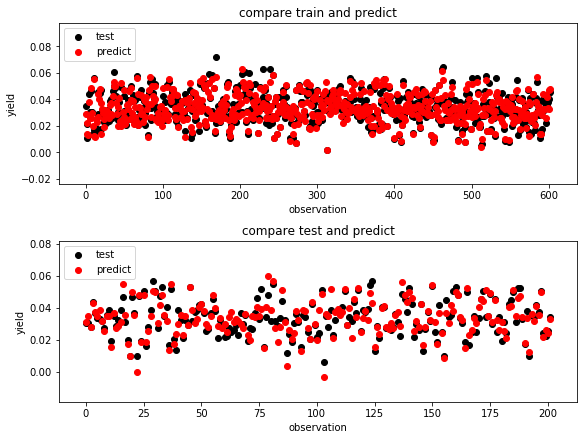

In [12]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 107
data_parameters['extra_parameters'] = ['bollsize', 'bollnum', 'bollvol']

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 500
model_parameters['verbose'] = 1
model_parameters['layer'] = [64]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

(805, 6)
(805, 6)
(805, 6)
(805, 20)
(805,)
Iteration:  0 		Error:  1801.0744839746185 	scale factor:  0.02
Iteration:  1 		Error:  1.5403531019562315 	scale factor:  0.007407407407407407
Iteration:  2 		Error:  0.036244538163464984 	scale factor:  0.0027434842249657062
Iteration:  3 		Error:  0.035000426887141806 	scale factor:  0.0027434842249657062
Iteration:  4 		Error:  0.03437710403568139 	scale factor:  0.0027434842249657062
Iteration:  5 		Error:  0.03370347513276626 	scale factor:  0.0027434842249657062
Iteration:  6 		Error:  0.03306452149073731 	scale factor:  0.0027434842249657062
Iteration:  7 		Error:  0.03251002183705806 	scale factor:  0.0027434842249657062
Iteration:  8 		Error:  0.0320474372564268 	scale factor:  0.0027434842249657062
Iteration:  9 		Error:  0.03166816653272893 	scale factor:  0.0027434842249657062
Iteration:  10 		Error:  0.0313591601602469 	scale factor:  0.0027434842249657062
Iteration:  11 		Error:  0.03110748960474595 	scale factor:  0.0027434842

Iteration:  98 		Error:  0.028851450781352577 	scale factor:  0.0001393834387525126
Iteration:  99 		Error:  0.02883316994469903 	scale factor:  0.0001393834387525126
Iteration:  100 		Error:  0.028813506711774375 	scale factor:  0.0001393834387525126
Iteration:  101 		Error:  0.02879304888647549 	scale factor:  0.0001393834387525126
Iteration:  102 		Error:  0.028772660635999307 	scale factor:  0.0001393834387525126
Iteration:  103 		Error:  0.028753535768216057 	scale factor:  0.0001393834387525126
Iteration:  104 		Error:  0.028737266779966537 	scale factor:  0.0001393834387525126
Iteration:  105 		Error:  0.0287259108275908 	scale factor:  0.0001393834387525126
Iteration:  106 		Error:  0.028721997339753263 	scale factor:  0.0001393834387525126
Iteration:  107 		Error:  0.028561609365298394 	scale factor:  0.00037633528463178407
Iteration:  108 		Error:  0.028549488085035945 	scale factor:  0.00037633528463178407
Iteration:  109 		Error:  0.028536888082255803 	scale factor:  0.0003

Iteration:  194 		Error:  0.027376409870471227 	scale factor:  0.00037633528463178407
Iteration:  195 		Error:  0.027366333005894142 	scale factor:  0.00037633528463178407
Iteration:  196 		Error:  0.02735630933209448 	scale factor:  0.00037633528463178407
Iteration:  197 		Error:  0.027346335760433133 	scale factor:  0.00037633528463178407
Iteration:  198 		Error:  0.02733640940446791 	scale factor:  0.00037633528463178407
Iteration:  199 		Error:  0.027326527573307172 	scale factor:  0.00037633528463178407
Iteration:  200 		Error:  0.02732504893014859 	scale factor:  0.0001393834387525126
Iteration:  201 		Error:  0.02729420596116442 	scale factor:  0.0001393834387525126
Iteration:  202 		Error:  0.027263980137290682 	scale factor:  0.0001393834387525126
Iteration:  203 		Error:  0.027234422825640824 	scale factor:  0.0001393834387525126
Iteration:  204 		Error:  0.027205620578593413 	scale factor:  0.0001393834387525126
Iteration:  205 		Error:  0.02717763488288017 	scale factor:  0

Iteration:  291 		Error:  0.024734381194320396 	scale factor:  0.0001393834387525126
Iteration:  292 		Error:  0.02471607551118995 	scale factor:  0.0001393834387525126
Iteration:  293 		Error:  0.02469783614595617 	scale factor:  0.0001393834387525126
Iteration:  294 		Error:  0.024679654972689775 	scale factor:  0.0001393834387525126
Iteration:  295 		Error:  0.02466152646604777 	scale factor:  0.0001393834387525126
Iteration:  296 		Error:  0.02464344773843295 	scale factor:  0.0001393834387525126
Iteration:  297 		Error:  0.024625418481046775 	scale factor:  0.0001393834387525126
Iteration:  298 		Error:  0.02460744079808154 	scale factor:  0.0001393834387525126
Iteration:  299 		Error:  0.024589519017047982 	scale factor:  0.0001393834387525126
Iteration:  300 		Error:  0.024571659371825063 	scale factor:  0.0001393834387525126
Iteration:  301 		Error:  0.024553869666459248 	scale factor:  0.0001393834387525126
Iteration:  302 		Error:  0.024536158880633548 	scale factor:  0.00013

Iteration:  388 		Error:  0.023240195694398846 	scale factor:  0.0001393834387525126
Iteration:  389 		Error:  0.023221593673188216 	scale factor:  0.0001393834387525126
Iteration:  390 		Error:  0.023202849439771786 	scale factor:  0.0001393834387525126
Iteration:  391 		Error:  0.023183968933893295 	scale factor:  0.0001393834387525126
Iteration:  392 		Error:  0.02316495908607072 	scale factor:  0.0001393834387525126
Iteration:  393 		Error:  0.023145827739918537 	scale factor:  0.0001393834387525126
Iteration:  394 		Error:  0.02312658352789555 	scale factor:  0.0001393834387525126
Iteration:  395 		Error:  0.02310723569005899 	scale factor:  0.0001393834387525126
Iteration:  396 		Error:  0.023087793872011004 	scale factor:  0.0001393834387525126
Iteration:  397 		Error:  0.02306826788638149 	scale factor:  0.0001393834387525126
Iteration:  398 		Error:  0.023048667487950026 	scale factor:  0.0001393834387525126
Iteration:  399 		Error:  0.023029002128237046 	scale factor:  0.0001

Iteration:  485 		Error:  0.02053160430299465 	scale factor:  5.162349583426392e-05
Iteration:  486 		Error:  0.020517939041613673 	scale factor:  5.162349583426392e-05
Iteration:  487 		Error:  0.020504787084545652 	scale factor:  5.162349583426392e-05
Iteration:  488 		Error:  0.020492177535496623 	scale factor:  5.162349583426392e-05
Iteration:  489 		Error:  0.02048027553006574 	scale factor:  5.162349583426392e-05
Iteration:  490 		Error:  0.02046931025278811 	scale factor:  5.162349583426392e-05
Iteration:  491 		Error:  0.020459491178214235 	scale factor:  5.162349583426392e-05
Iteration:  492 		Error:  0.02045093712866596 	scale factor:  5.162349583426392e-05
Iteration:  493 		Error:  0.020443636148837777 	scale factor:  5.162349583426392e-05
Iteration:  494 		Error:  0.02043744257584786 	scale factor:  5.162349583426392e-05
Iteration:  495 		Error:  0.02043210564159865 	scale factor:  5.162349583426392e-05
Iteration:  496 		Error:  0.020427316492842903 	scale factor:  5.162349

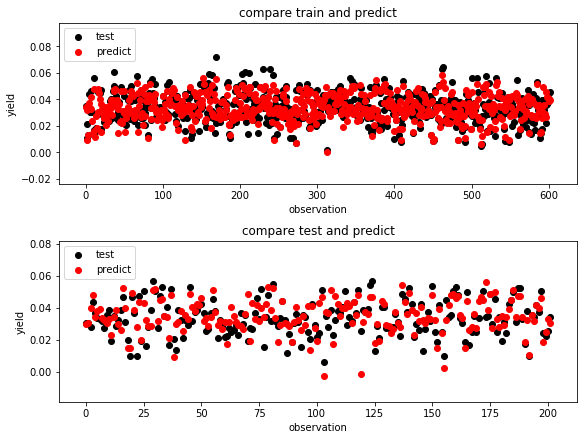

In [13]:
data_parameters = {}
model_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['file_parameters'] = ['ch', 'cv', 'cc']

data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 107
data_parameters['extra_parameters'] = []

data_parameters['one_hot_encoded_parameters'] = ['irrigation']

model_parameters['k_max'] = 500
model_parameters['verbose'] = 1
model_parameters['layer'] = [64]
model_parameters['dampconst'] = 2.7
model_parameters['dampfac'] = 0.02
model_parameters['E_stop'] = 0.005


#data Type
data_func = cottonYieldData

akashProcess(model_parameters, data_parameters, data_func)

In [19]:
#build model that have 2 hidden layers (64, 64)
def buildRegressionModel(model_shape, input_shape, optimizer, loss, metrics, drop_out=None, regularizer_l1=None, regularizer_l2=None, kernel_initializer = 'uniform', drop_out_rate = 0.25):

    # Define a Keras sequential model
    model = keras.Sequential()
    # Define the first dense layer
    for (i, size) in enumerate(model_shape):
        if i ==0:
            model.add(keras.layers.Dense(size, activation='relu', input_shape=[input_shape], kernel_regularizer=regularizer_l2,
                        activity_regularizer=regularizer_l1, kernel_initializer=kernel_initializer))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
        else:
            model.add(keras.layers.Dense(size, activation='relu', kernel_regularizer=regularizer_l2, kernel_initializer=kernel_initializer,
                        activity_regularizer=regularizer_l1))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1, kernel_initializer=kernel_initializer))
    
    #compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [20]:
def trainModel(x_data, y_data, input_shape, parameters):    
    #Build Hypterparameter
    sizes = parameters['sizes'] 
    shapes = parameters['shapes']
    drop_out = parameters['drop_out'] 
    regularizer_l1 = parameters['regularizer_l1']
    regularizer_l2 = parameters['regularizer_l2']
    kernel_initializer = parameters['kernel_initializer']
    drop_out_rate = parameters['drop_out_rate']
    #Compile Hyperparameter
    optimizer = parameters['optimizer']
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = parameters['loss']
    #loss = 'mae'
    metrics = parameters['metrics']

    #Callback Hyperparameter
    early_stopping = parameters['early_stopping']
    if early_stopping:
        callbacks = [early_stopping]
    else:
        callbacks = None
    verbose = parameters['verbose']
    
    #Train Hyperparameter
    epochs = parameters['epochs']
    validation_split = parameters['validation_split'] 
    
    #Test Train Split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    
    histories ={}
    models = {}
    #build and train model
    for (i, size) in enumerate(sizes):
        models[size] = buildRegressionModel(shapes[i], input_shape, optimizer, loss, metrics, drop_out = drop_out, kernel_initializer = kernel_initializer, 
                                     regularizer_l1=regularizer_l1, regularizer_l2 =regularizer_l2)
        histories[size] = models[size].fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid), 
                                  callbacks = callbacks, verbose = verbose)
        
        
    #plot results
    colors = ['red', 'blue', 'green', 'yellow']
    plt.figure()
    for i, size in enumerate(sizes):
        data_history = histories[size].history
        loss = data_history['loss']
        val_loss = data_history['val_loss']
        plt.plot(val_loss, color=colors[i], linestyle = '--', label = size + '_val_loss')
        plt.plot(loss, color=colors[i], linestyle = ':', label = size +'_loss')
    
    plt.legend(loc = 'upper left' )
    plt.xlabel = 'epochs'
    plt.ylabel = 'loss'
    
    
    #Show R2 scores
    for i, size in enumerate(sizes):
        #train score
        pred_train = models[size].predict(x_train)
        train_compare = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': pred_train.flatten()})
        train_r2_score = r2_score(train_compare.y_train, train_compare.y_train_pred)
        print(size + ' train r2 score = ', train_r2_score, '/ 1.0')
        
        #test score
        pred_test = models[size].predict(x_test)
        test_compare = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': pred_test.flatten()})
        test_r2_score = r2_score(test_compare.y_test, test_compare.y_test_pred)
        print(size+' test r2 score = ', test_r2_score, '/ 1.0')
        
    return (models, histories)

(802, 6)
(802, 6)
(802, 12)
(802, 15)
(802, 17)
(802, 17)
(802,)
default train r2 score =  0.7412299598478378 / 1.0
default test r2 score =  0.6707265232724129 / 1.0
medium train r2 score =  0.7547593692312067 / 1.0
medium test r2 score =  0.6656440464957959 / 1.0
small train r2 score =  0.7423326671344722 / 1.0
small test r2 score =  0.6679758132211238 / 1.0
tiny train r2 score =  0.7648554387172473 / 1.0
tiny test r2 score =  0.6834347407415284 / 1.0


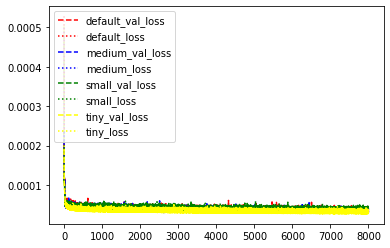

In [48]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default', 'medium']
parameters['shapes'] = [[64,64,64,64], [64,64, 64], [64, 64], [64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = True
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.001

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
# parameters['optimizer'] = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.00001
parameters['patience'] = 5000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 8000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = ''
data_parameters['grnn'] = True
data_parameters['interval_day'] = 7
data_parameters['limit_day'] = 105
data_parameters['remove_bad_yield'] = False
data_parameters['file_parameters'] = ['ch', 'cv']
data_parameters['extra_parameters'] = ['bollvol', 'bollnum', 'bollsize']
data_parameters['one_hot_encoded_parameters'] = ['irrigation']

#data Type
data_func = cottonYieldData

models, histories = process(parameters, data_parameters, data_func)